In [1]:
import os
import scvi
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, 
                     fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png2x')

[rank: 0] Global seed set to 0


In [2]:
from scipy.io import mmwrite
from scipy.sparse import issparse, csr_matrix
# Check if a matrix is sparse and convert to sparse if not
def to_sparse(matrix):
    if not issparse(matrix):
        sparse_matrix = csr_matrix(matrix)
        return sparse_matrix
    return matrix

# Define a function to export a layer to mtx.gz and barcode/feature TSV files
def export_layer_to_mtx_and_tsv(adata, layer_name, output_dir):
    # Create a subdirectory for the current layer
    layer_dir = os.path.join(output_dir, layer_name)
    os.makedirs(layer_dir, exist_ok=True)

    # Extract the layer as a dense matrix
    matrix = to_sparse(adata.layers[layer_name]).T

    # Save the dense matrix in mtx format
    mmwrite(os.path.join(layer_dir, f"{layer_name}"), matrix)

    # Convert barcode and feature Index objects to DataFrames
    barcodes_df = pd.DataFrame({'barcode': adata.obs.index})
    features_df = pd.DataFrame({'feature': adata.var.index})

    # Save barcode and feature DataFrames as TSV files
    barcodes_df.to_csv(os.path.join(layer_dir, f"{layer_name}_barcodes.tsv.gz"), sep='\t', compression='gzip', index=False, header=False)
    features_df.to_csv(os.path.join(layer_dir, f"{layer_name}_features.tsv.gz"), sep='\t', compression='gzip', index=False, header=False)

# Output directory where the subdirectories will be created for each layer
output_dir = "exported_data"

In [3]:
adata = sc.read_h5ad('../01_Libraries_Integration_and_Analysis---scVI/Adata_Objects/01f_AllGenes_Clustered_And_Annotated_Cells.h5ad')


In [4]:
adata

AnnData object with n_obs × n_vars = 263070 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'Celltype', 'Cell_Subtype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25', 'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50', 'OrigIdent_Celltype', 'Dose_Time'
    uns: 'Cell_Subtype_colors', 'Celltype_Wilcoxon', 'Celltype_colors', 'Dose_colors', 'OrigIdent_colors', 'Time_colors', 'doublet_info_colors', 'leiden', 'leiden_scVI_res_0.25_colors', 'leiden_scVI_res_0.5_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p_counts'
    obsp: 'connectivities', 'distances'

In [7]:
adata.obs['cell_type__custom'] = adata.obs['Celltype']
adata.obs['cell_type_orig__custom'] = adata.obs['Celltype']
adata.obs['Celltype_Time'] = adata.obs['Celltype'].astype(str) + "_" + adata.obs['Time'].astype(str)
adata.obs['Celltype_Dose'] = adata.obs['Celltype'].astype(str) + "_" + adata.obs['Dose'].astype(str)
adata.obs['Celltype_Dose_Time'] = adata.obs['Celltype'].astype(str) + "_" + adata.obs['Dose'].astype(str) + "_" + adata.obs['Time'].astype(str)

In [7]:
adata.layers

Layers with keys: counts, log1p_counts

In [ ]:
# Export each layer
for layer_name in ["log1p_counts", "counts"]: 
    export_layer_to_mtx_and_tsv(adata, layer_name, output_dir)

print("Exported data successfully.")

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


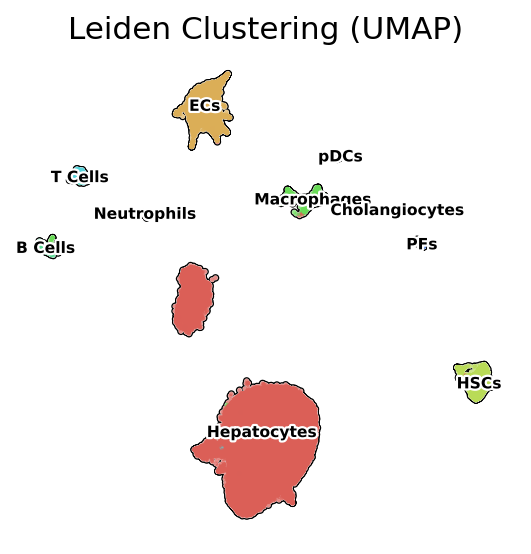

In [8]:
# Overview
sc.pl.umap(adata, add_outline=True, legend_loc='on data', color='Celltype',
           legend_fontsize=7, legend_fontoutline=2, frameon=False, size = 16,
           title = 'Leiden Clustering (UMAP)')

In [9]:
cell_type_dict = {'Hepatocytes':"hepatocyte", 
                  'ECs':"endothelial cell", 
                  'HSCs':"hepatic stellate cell", 
                  'Macrophages':"macrophage", 
                  'B Cells':"B cell", 
                  'T Cells':"T cell", 
                  'PFs':"hepatic portal fibroblast", 
                  'Cholangiocytes':"cholangiocyte",
                  'pDCs':"plasmacytoid dendritic cell",
                  'Neutrophils':"neutrophil"
                 }

cell_type_ontology_dict = {'Hepatocytes':"CL_0000182", 
                           'ECs':"CL_0000115", 
                           'HSCs':"CL_0000632", 
                           'Macrophages':"CL_0000235", 
                           'B Cells':"CL_0000236", 
                           'T Cells':"CL_0000084", 
                           'PFs':"CL_0009100", 
                           'Cholangiocytes':"CL_1000488",
                           'pDCs':"CL_0000784",
                           'Neutrophils':"CL_0000775"
                          }

adata.obs['cell_type__custom'] = adata.obs['Celltype']
adata.obs['cell_type_orig__custom'] = adata.obs['Celltype']
celltype = []
celltype_ontology = []

for i in adata.obs.index:
    ct = adata[i, :].obs["cell_type__custom"].values.astype(str)[0]
    celltype.append(cell_type_dict[str(ct)])
    celltype_ontology.append(cell_type_ontology_dict[str(ct)])
        
adata.obs["cell_type__ontology_label"] = celltype  
adata.obs["cell_type"] = celltype_ontology  

In [10]:
adata.obs["tissue"] = 'Liver'

tissue_dict = {'Liver':"UBERON_0002107", 
                 }

tissue_dict2 = {'Liver':"liver",  
                 }
tissue_l = []
tissue_l2 = []

for i in adata.obs.index:
    ts = adata[i, :].obs["tissue"].values.astype(str)[0]
    tissue_l.append(tissue_dict[str(ts)])
    tissue_l2.append(tissue_dict2[str(ts)])
        
adata.obs["organ"] = tissue_l  
adata.obs["organ__ontology_label"] = tissue_l2  

In [11]:
# Create a dictionary to map Time values to age_day values
age_day_mapping = {2: 28, 
                   4: 28, 
                   8: 28, 
                   12: 28, 
                   18: 28,
                   24: 29, 
                   72: 31}

# Add the 'age_day' column based on the mapping
adata.obs['age_day'] = adata.obs['Time'].astype(int).map(age_day_mapping)

In [12]:
# Create a dictionary with your data
data = {
    ('NAME', 'TYPE'): adata.obs.index,
    ('biosample_id', 'group'): adata.obs.OrigIdent,
    ('donor_id', 'group'): adata.obs.OrigIdent,
    ('species', 'group'): ['NCBITaxon_10090'] * len(adata.obs.index),
    ('species__ontology_label', 'group'): ['Mus musculus'] * len(adata.obs.index),
    ('sex', 'group'): ['male'] * len(adata.obs.index),
    ('cell_type', 'group'): adata.obs.cell_type,
    ('cell_type_time', 'group'): adata.obs.Celltype_Time,    
    ('cell_type_dose', 'group'): adata.obs.Celltype_Dose, 
    ('cell_type_dose_time', 'group'): adata.obs.Celltype_Dose_Time, 
    ('cell_type__ontology_label', 'group'): adata.obs.cell_type__ontology_label,
    ('cell_type__custom', 'group'): adata.obs.cell_type__custom,
    ('disease', 'group'): ['PATO_0000461'] * len(adata.obs.index),
    ('disease__ontology_label', 'group'): ['normal'] * len(adata.obs.index),
    ('organ', 'group'): adata.obs.organ,
    ('organ__ontology_label', 'group'): adata.obs.organ__ontology_label,
    ('organism_age', 'numeric'): adata.obs.age_day, #['28'] * len(adata.obs.index),
    ('organism_age__unit', 'group'): ['UO_0000033'] * len(adata.obs.index),
    ('organism_age__unit_label', 'group'): ['day'] * len(adata.obs.index),
    ('library_preparation_protocol', 'group'): ['EFO_0009922'] * len(adata.obs.index),
    ('library_preparation_protocol__ontology_label', 'group'): ["10x 3' v3"] * len(adata.obs.index)
}

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(data)
display(df)

,NAME,biosample_id,donor_id,species,species__ontology_label,sex,cell_type,cell_type_time,cell_type_dose,cell_type_dose_time,...,cell_type__custom,disease,disease__ontology_label,organ,organ__ontology_label,organism_age,organism_age__unit,organism_age__unit_label,library_preparation_protocol,library_preparation_protocol__ontology_label
,TYPE,group,group,group,group,group,group,group,group,group,...,group,group,group,group,group,numeric,group,group,group,group
0,0,L001,L001,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_2,Hepatocytes_0,Hepatocytes_0_2,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,28,UO_0000033,day,EFO_0009922,10x 3' v3
1,1,L001,L001,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_2,Hepatocytes_0,Hepatocytes_0_2,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,28,UO_0000033,day,EFO_0009922,10x 3' v3
2,2,L001,L001,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_2,Hepatocytes_0,Hepatocytes_0_2,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,28,UO_0000033,day,EFO_0009922,10x 3' v3
3,3,L001,L001,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_2,Hepatocytes_0,Hepatocytes_0_2,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,28,UO_0000033,day,EFO_0009922,10x 3' v3
4,4,L001,L001,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_2,Hepatocytes_0,Hepatocytes_0_2,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,28,UO_0000033,day,EFO_0009922,10x 3' v3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263069,263069,L138,L138,NCBITaxon_10090,Mus musculus,male,CL_0000115,ECs_72,ECs_30,ECs_30_72,...,ECs,PATO_0000461,normal,UBERON_0002107,liver,31,UO_0000033,day,EFO_0009922,10x 3' v3
263070,263070,L138,L138,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_72,Hepatocytes_30,Hepatocytes_30_72,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,31,UO_0000033,day,EFO_0009922,10x 3' v3
263071,263071,L138,L138,NCBITaxon_10090,Mus musculus,male,CL_0000182,Hepatocytes_72,Hepatocytes_30,Hepatocytes_30_72,...,Hepatocytes,PATO_0000461,normal,UBERON_0002107,liver,31,UO_0000033,day,EFO_0009922,10x 3' v3


In [13]:
df.to_csv('./exported_data/metadata_all.tsv', index=False, sep='\t')

In [14]:
# Extract UMAP coordinates for all cells
umap_all = adata.obsm["X_umap"]

# Create a DataFrame with name, x, and y columns
df_all = pd.DataFrame({
    'name': adata.obs.index,
    'x': umap_all[:, 0],
    'y': umap_all[:, 1]
})


In [15]:
# Save the DataFrames to tab-delimited files with the specified format
with open('./exported_data/umap_all.tsv', 'w') as f:
    f.write("NAME\tX\tY\nTYPE\tnumeric\tnumeric\n")
    df_all.to_csv(f, sep='\t', index=False, header=False)


In [16]:
obs_metadata_df = df

## Add the SCP metadata columns into the adata object

In [17]:
result = (adata.obs.index == obs_metadata_df.index).all()
print(result)

True


In [18]:
for c in obs_metadata_df.columns[3:]:
    print(c[0])
    adata.obs[str(c[0])] = obs_metadata_df[c]

species
species__ontology_label
sex
cell_type
cell_type_time
cell_type_dose
cell_type_dose_time
cell_type__ontology_label
cell_type__custom
disease
disease__ontology_label
organ
organ__ontology_label
organism_age
organism_age__unit
organism_age__unit_label
library_preparation_protocol
library_preparation_protocol__ontology_label


In [19]:
adata.obs.columns

Index(['Dose', 'Time', 'OrigIdent', 'Celltype', 'Cell_Subtype',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype',
       'doublet_scores', 'predicted_doublets', 'doublet_info',
       'leiden_scVI_res_0.05', 'leiden_scVI_res_0.1', 'leiden_scVI_res_0.25',
       'leiden_scVI_res_0.5', 'leiden_scVI_res_0.75', 'leiden_scVI_res_1.50',
       'OrigIdent_Celltype', 'Dose_Time', 'cell_type__custom',
       'cell_type_orig__custom', 'Celltype_Time', 'Celltype_Dose',
       'Celltype_Dose_Time', 'cell_type__ontology_label', 'cell_type',
       'tissue', 'organ', 'organ__ontology_label', 'age_day', 'species',
       'species__ontology_label', 'sex', 'cell_type_time', 'cell_type_dose',
       'cell_type_dose_time', 'disease', 'disease__ontology_label',
       'organism_age', 'organism_age__unit', 'organism_age__unit_label',
       'library_preparation_protocol',
       'library_preparation_protocol_

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


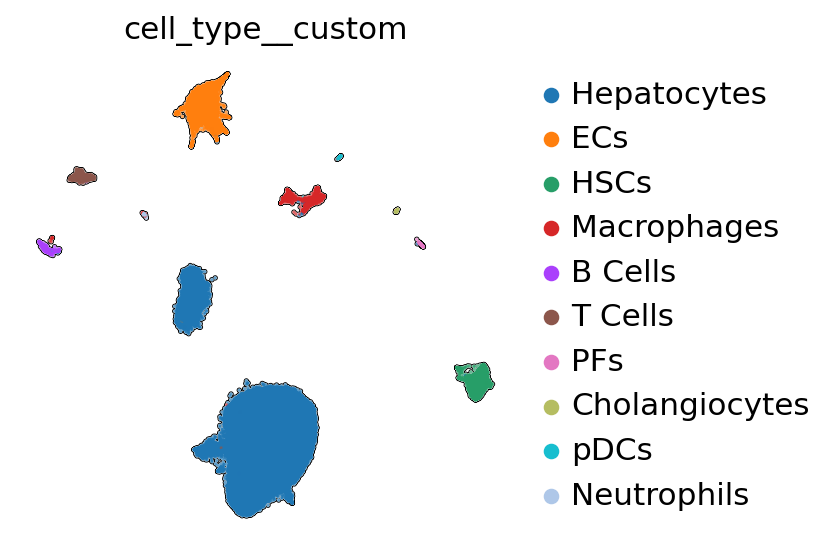

In [20]:
sc.pl.umap(adata, add_outline=True, color='cell_type__custom',
           legend_fontsize=14, legend_fontoutline=2, frameon=False, size = 8)

In [21]:
adata.write_h5ad('../01_Libraries_Integration_and_Analysis---scVI/Adata_Objects/07a_AllGenes_Clustered_And_Annotated_Cells_SCP_Annotated.h5ad')
